# Gradient-weighted Class Activation Mapping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import convert_to_grid, save_data_pickle, load_pickle, load_data_from_pickle
from import_notebook import load_function_from_notebook
unprocess_record = load_function_from_notebook("SPC.ipynb", "unprocess_record")
reprocess = load_function_from_notebook("SPC.ipynb", "reprocess")
print_image = load_function_from_notebook("SPC.ipynb", "print_image")
downscale = load_function_from_notebook("SPC.ipynb", "downscale")
upscale_image = load_function_from_notebook("SPC.ipynb", "upscale_image")
from PIL import Image, ImageDraw

In [81]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(1)

In [23]:
import tensorflow as tf
# Get original model
original_model_name = 'model-3x3.keras'
original_model = tf.keras.models.load_model(original_model_name)
original_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,356,819 (47.14 MB)

 Trainable params: 4,118,939 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,237,880 (31.43 MB)

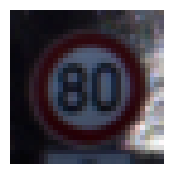

In [85]:
# Get image
source_record = x_train[89]
source_image = unprocess_record(source_record)
print_image(source_image,"")

In [24]:
# Get prediction
label_text = load_function_from_notebook('CNN.ipynb', 'label_text')
labels=label_text()
test_dataset = np.array([source_record])
predictions = original_model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
print("Prediction :",labels[predicted_classes[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction : Speed limit (80km/h)


##  Get last layer

In [86]:
import tensorflow as tf
# Accès à une couche spécifique par nom
my_layer = model.get_layer('dense_5')
input_shape = (1, 500)
# Créer des données d'entrée aléatoires
example_input = np.random.random(input_shape)
# Utilisation de la couche avec des données d'entrée
output = my_layer(example_input)
# Afficher la forme de la sortie
print("Shape of output:", output.shape)
print(type(example_input))

Shape of output: (1, 43)
<class 'numpy.ndarray'>


## Get first layer

In [96]:
import tensorflow as tf
my_layer = model.get_layer('conv2d_2')
input_shape = (1, 32, 32, 3)
# Créer des données d'entrée aléatoires
example_input = tf.random.normal(input_shape)
#print(example_input)
# Utilisation de la couche avec des données d'entrée
output = my_layer(example_input)
# Afficher la forme de la sortie
#print("Shape of output:", output.shape)

## Get convolutional layer activation scores for input x

In [136]:
# Sélectionner la couche dont vous souhaitez obtenir les activations
conv_layer_name = 'conv2d_2'  # Remplacez par le nom de la couche que vous souhaitez
conv_layer = original_model.get_layer(layer_name)
conv_layer_input = conv_layer.input
conv_layer_output = conv_layer.output
print(type(original_model))
print(type(conv_layer_input))
print(type(conv_layer_output))
# Extract submodel
intermediate_layer_model = tf.keras.Model(inputs=conv_layer_input,outputs=conv_layer_output)
activations = intermediate_layer_model.predict(shaped_source_record)
print("Shape of activations:", activations.shape)

<class 'keras.src.models.sequential.Sequential'>
<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Shape of activations: (1, 32, 32, 32)


## Get gradients from input

In [141]:
# Calcul des gradients à l'aide de tf.GradientTape()
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    preds = original_model(input_tensor)
    class_idx = tf.argmax(preds[0])
    output = preds[:, class_idx]

# Calcul des gradients de la sortie par rapport à l'entrée
grads = tape.gradient(output, input_tensor)[0]  # Utilisez [0] pour déballer le résultat

In [139]:
# INPUT : conerte into TensorFlow tensor
print(type(source_record))
shaped_source_record = np.array([source_record]) 
input_tensor = tf.convert_to_tensor(shaped_source_record, dtype=tf.float32)
# Calculer les gradients à l'aide de tf.GradientTape()
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    # Propagation avant
    preds = original_model(input_tensor)
    # Sélectionner la sortie de la dernière couche (adapter selon votre modèle)
    last_layer_output = preds[:, -1]  # Par exemple, dernière sortie du modèle
# Calcul des gradients par rapport à la sortie de la dernière couche
gradients = tape.gradient(last_layer_output, input_tensor)
# Affichage pour vérification
print("Input Tensor Shape:", input_tensor.shape)
print("Last Layer Output Shape:", last_layer_output.shape)
print("Gradients Shape:", gradients.shape)
# Affichage des gradients
#print("Gradients shape:", gradients.shape)
#print("Gradients:")
#print(gradients.numpy())  # Afficher les valeurs des gradients sous forme de tableau NumPy

<class 'numpy.ndarray'>
Input Tensor Shape: (1, 32, 32, 3)
Last Layer Output Shape: (1,)
Gradients Shape: (1, 32, 32, 3)


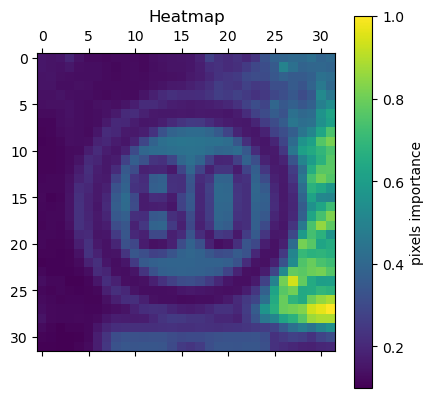

In [146]:
import cv2  # Ajouter l'importation de cv2
# Affichage de la carte de chaleur avec légende
plt.matshow(heatmap[0])
plt.colorbar(label='pixels importance')  # Ajouter une légende pour indiquer l'importance
plt.title('Heatmap')
plt.show()